In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
# Database Reading and Manipulation
import pandas as pd

# Linear Algebra
import numpy as np

# Plotting
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import matplotlib.ticker as ticker

# Time
import time

# Random and os for reproducibility
import random
import os

# Model Selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

# Modeling
from sklearn.linear_model import LinearRegression
import tensorflow as tf

# Modeling
from xgboost import XGBRegressor
from xgboost import plot_importance

# Processing
from sklearn.preprocessing import StandardScaler

# Metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score

# Pipeline
from sklearn.pipeline import Pipeline

# Making keras compatible with scikit learn api
# https://scikit-learn.org/stable/developers/develop.html
from sklearn.base import RegressorMixin

from src.utils.time_series_procs import split_sequences

<IPython.core.display.Javascript object>

# Functions and definitions

In [3]:
def plot_predictions(model, df, index, x, y):
    d = df["Date"].values
    test_series = pd.DataFrame({"ccs28": y}, index=pd.to_datetime(d))
    pred_series = model.predict(scaler.transform(x))
    pred_series = pd.DataFrame({"ccs28-pred": pred_series}, index=pd.to_datetime(d))

    fig, ax = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(15, 7))

    test_series.plot(ax=ax)
    ax.axvline(test_series.index[index], color="r")  # end of train dataset
    pred_series[index:].plot(ax=ax)
    ax.grid(which="both")
    ax.legend(
        ["train and test series", "end of train series", "predicted"], loc="upper left"
    )
    # ax.set_xlabel('Period', labelpad=20, fontsize=15)
    ax.set_ylabel("Compressive Strength - MPa", labelpad=20, fontsize=15)
    plt.show()

<IPython.core.display.Javascript object>

In [4]:
def plot_scores_box_plot(scores, repeats, n_splits):
    plt.figure(figsize=(15, 8))
    plt.boxplot(
        scores.reshape((repeats, n_splits)),
        labels=[str(r) for r in range(1, repeats + 1)],
        showmeans=True,
    )
    plt.ylabel("RMSE", labelpad=20, fontsize=15)
    plt.xlabel("Repeats", labelpad=20, fontsize=15)
    plt.show()

<IPython.core.display.Javascript object>

In [5]:
class BlockingTimeSeriesSplit:
    def __init__(self, n_splits):
        self.n_splits = n_splits

    def get_n_splits(self, X, y, groups):
        return self.n_splits

    def split(self, X, y=None, groups=None):
        n_samples = len(X)
        k_fold_size = n_samples // self.n_splits
        indices = np.arange(n_samples)

        margin = 0
        for i in range(self.n_splits):
            start = i * k_fold_size
            stop = start + k_fold_size
            mid = int(0.5 * (stop - start)) + start
            yield indices[start:mid], indices[mid + margin : stop]


# Reference: https://goldinlocks.github.io/Time-Series-Cross-Validation/

<IPython.core.display.Javascript object>

In [6]:
def repeated_blocking_time_series(
    Estimator, Transform, x, y, train_period, test_period, repeats=10, params=None
):
    results = []
    max_samples = x.shape[0]
    y_results = []
    for _ in range(repeats):
        i = 0
        scores = []
        for _ in range(0, max_samples // (train_period + test_period)):
            scaler = Transform()
            model = Estimator() if params is None else Estimator(**params)
            x_train = x[i : i + train_period]
            y_train = y[i : i + train_period]
            x_test = x[i + train_period : i + train_period + test_period]
            y_test = y[i + train_period : i + train_period + test_period]
            x_train = scaler.fit_transform(x_train)
            x_test = scaler.transform(x_test)

            model.fit(x_train, y_train)

            y_train_pred = model.predict(x_train)
            y_test_pred = model.predict(x_test)
            y_results.append(y_test_pred)
            scores.append(
                score_regression_metrics(y_train, y_train_pred, y_test, y_test_pred)
            )
            i += train_period + test_period

        scores_final = {key: [] for key, _ in scores[0].items()}
        for scores_dict in scores:
            for key, value in scores_dict.items():
                scores_final[key] += [value]
        results.append(scores_final)
    return results, y_results

<IPython.core.display.Javascript object>

In [7]:
def repeated_blocking_time_series_nn(
    Estimator, Transform, x, y, train_period, test_period, repeats=10, params=None
):
    results = []
    scores_final = None
    max_samples = x.shape[0]
    y_results = [[] for _ in range(repeats)]

    for repeat in range(repeats):
        i = 0
        scores = []
        for _ in range(0, max_samples // (train_period + test_period)):
            if Transform is not None:
                scaler = Transform()
                x_train = scaler.fit_transform(x_train)
                x_test = scaler.transform(x_test)

            model = Estimator() if params is None else Estimator(**params)
            x_train = x[i : i + train_period]
            y_train = y[i : i + train_period]
            x_test = x[i + train_period : i + train_period + test_period]
            y_test = y[i + train_period : i + train_period + test_period]

            model.fit(x_train, y_train)

            y_train_pred = model.predict(x_train)
            y_test_pred = model.predict(x_test)
            y_results[repeat].append(y_test_pred)
            scores.append(
                score_regression_metrics(y_train, y_train_pred, y_test, y_test_pred)
            )
            i += train_period + test_period

        if scores_final is None:
            scores_final = {key: [] for key, _ in scores[0].items()}
        for scores_dict in scores:
            for key, value in scores_dict.items():
                scores_final[key] += [value]
        results.append(scores_final)
    return results, y_results

<IPython.core.display.Javascript object>

In [8]:
def print_scores(scores, METRICS, METRICS_DICT):
    for phase in ["train", "test"]:
        print("******")
        print(f"[{phase.upper()}]")
        print("******")
        for metric in METRICS:
            name = METRICS_DICT[metric]
            print(
                f"{name}: %.3f (%.3f)"
                % (
                    np.abs(np.mean(scores[f"{phase}_" + metric])),
                    np.std(scores[f"{phase}_" + metric]),
                )
            )
        print("\n======================\n")

<IPython.core.display.Javascript object>

In [9]:
def score_regression_metrics(y_train, y_train_pred, y_test, y_test_pred):
    TRAIN_RMSE = mean_squared_error(y_true=y_train, y_pred=y_train_pred, squared=False)
    TRAIN_MAE = mean_absolute_error(y_true=y_train, y_pred=y_train_pred)
    TRAIN_MAPE = mean_absolute_percentage_error(y_true=y_train, y_pred=y_train_pred)
    TRAIN_R2 = r2_score(y_true=y_train, y_pred=y_train_pred)

    TEST_RMSE = mean_squared_error(y_true=y_test, y_pred=y_test_pred, squared=False)
    TEST_MAE = mean_absolute_error(y_true=y_test, y_pred=y_test_pred)
    TEST_MAPE = mean_absolute_percentage_error(y_true=y_test, y_pred=y_test_pred)
    TEST_R2 = r2_score(y_true=y_test, y_pred=y_test_pred)

    scores = {
        "train_neg_root_mean_squared_error": TRAIN_RMSE,
        "train_neg_mean_absolute_error": TRAIN_MAE,
        "train_neg_mean_absolute_percentage_error": TRAIN_MAPE,
        "train_r2": TRAIN_R2,
        "test_neg_root_mean_squared_error": TEST_RMSE,
        "test_neg_mean_absolute_error": TEST_MAE,
        "test_neg_mean_absolute_percentage_error": TEST_MAPE,
        "test_r2": TEST_R2,
    }
    return scores

<IPython.core.display.Javascript object>

In [10]:
class MLP(RegressorMixin):
    def __init__(self):
        self.model = self.get_model()
        self.batch_size = 16
        self.epochs = 300
        self.verbose = 0

    def fit(self, X=None, y=None):
        self.model.fit(
            X, y, batch_size=self.batch_size, epochs=self.epochs, verbose=self.verbose
        )

    def predict(self, X=None):
        return self.model.predict(X)

    def get_model(self):
        model = tf.keras.Sequential()
        model.add(tf.keras.layers.Dense(units=16, activation="relu")),
        model.add(tf.keras.layers.Dropout(rate=0.10))
        model.add(tf.keras.layers.Dense(units=1))
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
            loss="mse",
            metrics=[tf.keras.metrics.RootMeanSquaredError(name="RMSE")],
        )
        return model

<IPython.core.display.Javascript object>

In [11]:
class LSTM(RegressorMixin):
    def __init__(self):
        self.model = self.get_model()
        self.batch_size = 32
        self.epochs = 200
        self.verbose = 0

    def fit(self, X=None, y=None):
        self.model.fit(
            X, y, batch_size=self.batch_size, epochs=self.epochs, verbose=self.verbose
        )

    def predict(self, X=None):
        return self.model.predict(X)

    def get_model(self):
        model = tf.keras.Sequential()
        model.add(tf.keras.layers.LSTM(units=32, activation="relu")),
        model.add(tf.keras.layers.Dropout(rate=0.10))
        model.add(tf.keras.layers.Dense(units=1))
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
            loss="mse",
            metrics=[tf.keras.metrics.RootMeanSquaredError(name="RMSE")],
        )
        return model

<IPython.core.display.Javascript object>

In [12]:
class StandardScaler3DShape:
    def __init__(self):
        self.scaler = StandardScaler()

    def fit_transform(self, X, y=None):
        X_new = self.scaler.fit_transform(X.reshape(-1, X.shape[-1])).reshape(X.shape)
        return X_new

    def fit(self, X, y=None):
        X_new = X.reshape(-1, X.shape[-1])
        self.scaler.fit(X_new)
        return self

    def transform(self, X, y=None):
        X_new = self.scaler.transform(X.reshape(-1, X.shape[-1])).reshape(X.shape)
        return X_new

<IPython.core.display.Javascript object>

## Cross Validation Plot

In [13]:
def plot_cv_indices(cv, X, y, ax, n_splits, lw=10):
    """Create a sample plot for indices of a cross-validation object."""

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0
        # Visualize the results
        ax.scatter(
            pd.Series(range(len(indices)), index=X.index),
            # range(len(indices)),
            [ii + 0.5] * len(indices),
            c=indices,
            marker="_",
            lw=lw,
            cmap=cmap_cv,
            vmin=-0.2,
            vmax=1.2,
        )

    # Formatting
    yticklabels = list(range(n_splits))
    # xticks = pd.to_datetime([dates[i] for i in range(0, len(dates), len(dates)//7)]).values
    # xticks=dates
    xticklabels = [dates[i] for i in range(0, len(dates), len(dates) // 7)]
    ax.set(
        yticks=np.arange(n_splits) + 0.5,
        yticklabels=yticklabels,
        xticklabels=xticklabels,
        # xticks=xticks,
        # xlabel="Sample index",
        ylabel="CV iteration",
        ylim=[n_splits + 0.2, -0.1],
        # xlim=[0, 1200],
    )
    # plt.gcf().autofmt_xdate()
    ax.set_title("{}".format(type(cv).__name__), fontsize=15)
    return ax

<IPython.core.display.Javascript object>

In [14]:
SEED = 47
METRICS = (
    "neg_root_mean_squared_error",
    "neg_mean_absolute_error",
    "neg_mean_absolute_percentage_error",
    "r2",
)
METRICS_DICT = {
    "neg_root_mean_squared_error": "RMSE",
    "neg_mean_absolute_error": "MAE",
    "neg_mean_absolute_percentage_error": "MAPE",
    "r2": "R2",
}

<IPython.core.display.Javascript object>

In [15]:
# Settings for Reproducibility


def set_seeds():
    os.environ["CUDA_VISIBLE_DEVICES"] = ""
    os.environ["PYTHONHASHSEED"] = str(SEED)
    tf.random.set_seed(SEED)
    np.random.seed(SEED)
    random.seed(SEED)


# https://stackoverflow.com/questions/36288235/how-to-get-stable-results-with-tensorflow-setting-random-seed

<IPython.core.display.Javascript object>

In [16]:
SEED = 47
n_splits = 5

PARAMS = {
    "objective": "reg:squarederror",
    "n_estimators": 50,
    "max_depth": 3,
    "eta": 0.09,
    "random_state": SEED,
    "verbosity": 0,
}

<IPython.core.display.Javascript object>

# All Cements - Dataset

## Reading the dataset

In [17]:
df = pd.read_csv("../../../data/processed/partner_ii/cement-shipping.csv")

<IPython.core.display.Javascript object>

In [18]:
dates = pd.to_datetime(df["sample_date"])
dates = dates.dt.date
x = df
y = df["strength_28d"]

<IPython.core.display.Javascript object>

# Cross Validation Plot of Examples

In [61]:
# https://goldinlocks.github.io/Time-Series-Cross-Validation/

<IPython.core.display.Javascript object>

In [63]:
n_splits = 5
cvs = [KFold, TimeSeriesSplit, BlockingTimeSeriesSplit]

for cv in cvs:
    this_cv = cv(n_splits=n_splits)
    fig, ax = plt.subplots(figsize=(10, 4))
    plot_cv_indices(this_cv, x.set_index(dates), y, ax, n_splits)

    fig.autofmt_xdate()
    ax.legend(
        [Patch(color=cmap_cv(0.8)), Patch(color=cmap_cv(0.02))],
        ["Testing set", "Training set"],
        loc=(1.02, 0.8),
    )
    plt.tight_layout()
    plt.xticks(rotation=10)
    fig.subplots_adjust(right=0.7)

plt.show()

<IPython.core.display.Javascript object>

### KFold Example

In [110]:
from sklearn.model_selection import KFold

/tmp/ipykernel_595358/1254042325.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set(


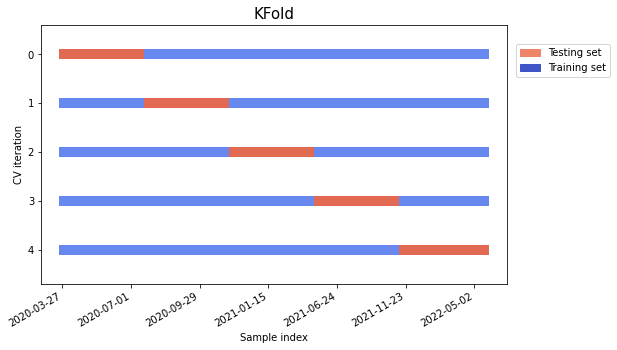

In [490]:
this_cv = KFold(n_splits=n_splits)
fig, ax = plt.subplots(figsize=(10, 5))
plot_cv_indices(this_cv, x.set_index(dates), y, ax, n_splits)
ax.legend([Patch(color=cmap_cv(.8)), Patch(color=cmap_cv(.02))],
          ['Testing set', 'Training set'], loc=(1.02, .8))
plt.tight_layout()
fig.subplots_adjust(right=.7)
fig.autofmt_xdate()
plt.show()

### TimeSeriesSplit Example

/tmp/ipykernel_595358/1254042325.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set(


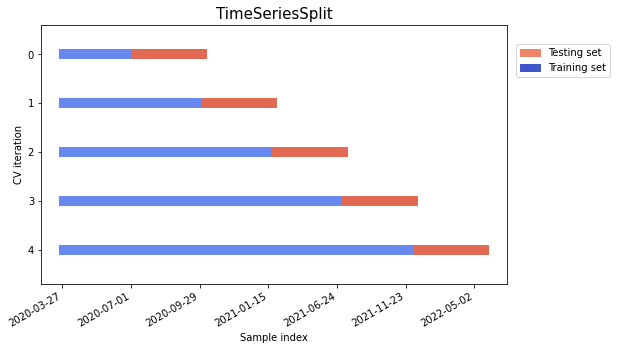

In [491]:
this_cv = TimeSeriesSplit(n_splits=n_splits)
fig, ax = plt.subplots(figsize=(10, 5))
plot_cv_indices(this_cv, x.set_index(dates), y, ax, n_splits)
ax.legend([Patch(color=cmap_cv(.8)), Patch(color=cmap_cv(.02))],
          ['Testing set', 'Training set'], loc=(1.02, .8))
plt.tight_layout()
fig.subplots_adjust(right=.7)
fig.autofmt_xdate()
plt.show()

### BlockingTimeSeriesSplit Example

/tmp/ipykernel_595358/1254042325.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set(


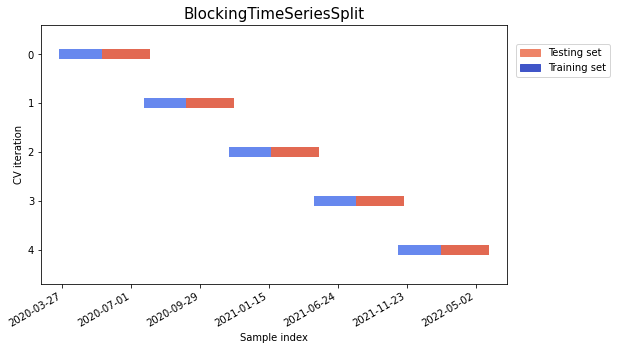

In [492]:
n_splits = 5
this_cv = BlockingTimeSeriesSplit(n_splits=n_splits)
fig, ax = plt.subplots(figsize=(10, 5))
plot_cv_indices(this_cv, x.set_index(dates), y, ax, n_splits)
ax.legend([Patch(color=cmap_cv(.8)), Patch(color=cmap_cv(.02))],
          ['Testing set', 'Training set'], loc=(1.02, .8))
plt.tight_layout()
fig.subplots_adjust(right=.7)
fig.autofmt_xdate()
plt.show()

# All Cements - Dataset

## Reading the dataset

In [21]:
df = pd.read_csv("../../../data/processed/partner_ii/cement-shipping.csv")

<IPython.core.display.Javascript object>

In [22]:
df["sample_date"] = pd.to_datetime(
    df["sample_date"],
).dt.date

<IPython.core.display.Javascript object>

# XGBoost

In [23]:
df_no_cs = df.drop(
    ["strength_1d", "strength_3d", "strength_7d"],
    axis=1,
).copy()

df_no_cs = df_no_cs.replace({-100: np.nan})
y = df_no_cs.pop("strength_28d").values
x = df_no_cs.drop(["sample_date"], axis=1)

<IPython.core.display.Javascript object>

## 1.5.7 Train 2 years and predicts two months every year

In [24]:
scores, y_results = repeated_blocking_time_series_nn(
    XGBRegressor,
    None,
    x,
    y,
    params=PARAMS,
    train_period=730,
    test_period=60,
    repeats=1,
)

print_scores(scores[0], METRICS, METRICS_DICT)

******
[TRAIN]
******
RMSE: 1.833 (0.000)
MAE: 1.471 (0.000)
MAPE: 0.033 (0.000)
R2: 0.698 (0.000)


******
[TEST]
******
RMSE: 1.716 (0.000)
MAE: 1.299 (0.000)
MAPE: 0.030 (0.000)
R2: 0.420 (0.000)




<IPython.core.display.Javascript object>

In [25]:
y_results_mean = np.mean(y_results, axis=0)
y_hat = y_results_mean.squeeze().squeeze().squeeze()

start = 730
step = 60
indices_start = [i for i in range(start, x.shape[0], start + step)]

index = [df["sample_date"][start : start + step].values for start in indices_start][0]

results_str = """           Mean  (std)
RMSE: 1.716 (0.000)
MAE:   1.299 (0.000)
MAPE: 0.030 (0.000)
R2:     0.420 (0.000)
"""

df = df.rename(
    {"sample_date": "Date", "strength_28d": "28 day Compressive strength"}, axis=1
)

<IPython.core.display.Javascript object>

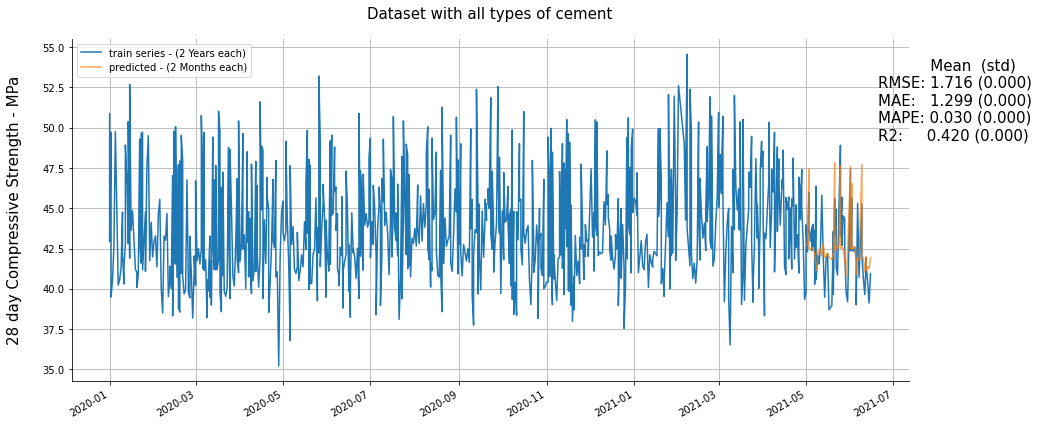

<IPython.core.display.Javascript object>

In [26]:
tmp = df[["Date", "28 day Compressive strength"]].dropna().copy()
tmp["Date"] = pd.to_datetime(tmp["Date"])
tmp = tmp.rename({"Production": "Date"}, axis=1)
tmp = tmp.set_index("Date")
tmp = tmp.iloc[: (start + step) * 1]

pred_series_0 = y_hat
pred_series_0 = pd.DataFrame({"ccs28-pred": pred_series_0}, index=pd.to_datetime(index))

# pred_series_1 = y_hat[1]
# pred_series_1 = pd.DataFrame(
#     {"ccs28-pred": pred_series_1}, index=pd.to_datetime(index[1])
# )


fig, ax = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(15, 7))

tmp.plot(ax=ax)
pred_series_0.plot(ax=ax, color="C1", alpha=0.7)
# pred_series_1.plot(ax=ax, color="C1", alpha=0.7)

ax.grid(which="both")
ax.legend(["28 day compressive strength"], loc="upper left")

# ax.set_xlabel("Dates", labelpad=20, fontsize=15)
ax.set_xlabel("", labelpad=20, fontsize=15)
ax.set_ylabel("Compressive Strength - MPa", labelpad=20, fontsize=15)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# ax.axvline(pred_series_0.index[0], color="r")  # end of train dataset
# ax.axvline(pred_series_1.index[0], color="r")  # end of train dataset

ax.legend(
    ["train series - (2 Years each)", "predicted - (2 Months each)"], loc="upper left"
)  # loc="upper left")

# ax.set_xlabel("Trains a year and a month and predict a month for each year", labelpad=20, fontsize=15)
ax.set_ylabel("28 day Compressive Strength - MPa", labelpad=20, fontsize=15)

ax.text(
    pred_series_0.index[-1] + pd.DateOffset(5),
    48,
    results_str,
    fontsize=15,
    verticalalignment="bottom",
    horizontalalignment="left",
    # multialignment="center",
    # fontweight="ultrabold"
)

ax.set_title("Dataset with all types of cement", fontsize=15, pad=20)

plt.show()

# 1. Linear Regression

<h2>Dataset: df_no_cs</h2> <br>In this dataset the CS1, CS3  and CS7 variables are not considered.

In [28]:
df_no_cs = df.drop(
    [
        "1 day Compressive strength",
        "3 day Compressive strength",
        "7 day Compressive strength",
    ],
    axis=1,
).copy()

y = df_no_cs.pop("28 day Compressive strength").values
x = df_no_cs.drop(["Date"], axis=1)

<IPython.core.display.Javascript object>

In [894]:
# results

## 1. Repeated KFold 
### Test set: RMSE: 1.794 (2.137)

### 2. Blocking Time Series Cross Validation

### Test set: RMSE: 8.630 (13.198)

### 3. Time Series Split Cross Validation

### Test set: RMSE: 19.104 (34.671)

## Blocking Time Series - Period Specific

# 1 - 1.208 (0.202)
# 2 - 1.535 (0.486)
# 3 - 1.182 (0.126)
# 4 - 0.890 (0.286) - BEST
# 5 - 1.011 (0.291)
# 6 - 1.265 (0.000)
# 7 - 1.278 (0.000)
# 8 - 1.614 (0.000)

## 1.1 Train 1 Year each and  predicteds 1 Month

In [29]:
scores, y_results = repeated_blocking_time_series(
    LinearRegression,
    StandardScaler,
    x,
    y,
    train_period=395,
    test_period=30,
    repeats=1,
)
print_scores(scores[0], METRICS, METRICS_DICT)

<IPython.core.display.Javascript object>

In [30]:
y_results_mean = sum(y_results) / len(y_results)
y_hat = y_results
start = 395
step = 30
indices_start = [i for i in range(start, x.shape[0], start + step)]
indices_start
index = [df["Date"][start : start + step].values for start in indices_start]

results_str = """           Mean  (std)
RMSE: 0.890 (0.286)
MAE:   0.689 (0.209)
MAPE: 0.016 (0.005)
R2:     0.970 (0.015)
"""

<IPython.core.display.Javascript object>

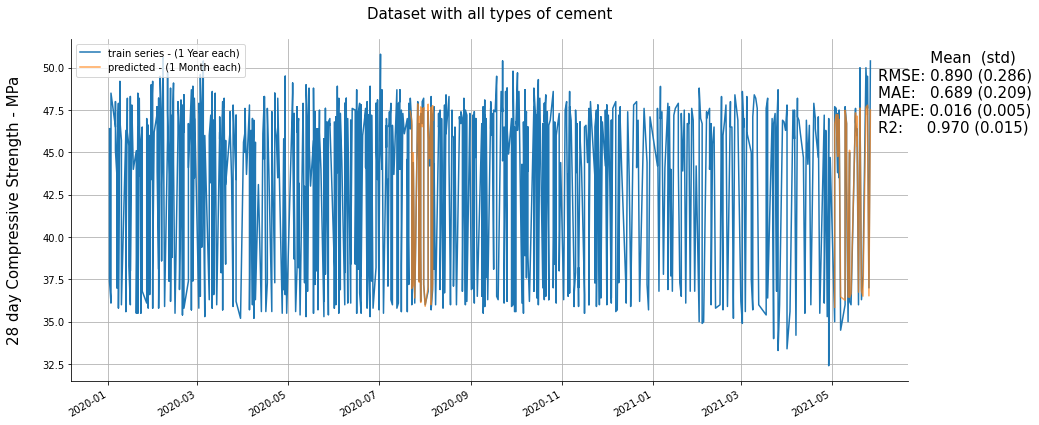

In [897]:
tmp = df[["Date", "28 day Compressive strength"]].dropna().copy()
tmp["Date"] = pd.to_datetime(tmp["Date"])
tmp = tmp.rename({"Production": "Date"}, axis=1)
tmp = tmp.set_index("Date")
tmp = tmp.iloc[: (start + step) * 2]

pred_series_0 = y_hat[0]
pred_series_0 = pd.DataFrame(
    {"ccs28-pred": pred_series_0}, index=pd.to_datetime(index[0])
)

pred_series_1 = y_hat[1]
pred_series_1 = pd.DataFrame(
    {"ccs28-pred": pred_series_1}, index=pd.to_datetime(index[1])
)


fig, ax = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(15, 7))

tmp.plot(ax=ax)
pred_series_0.plot(ax=ax, color="C1", alpha=0.7)
pred_series_1.plot(ax=ax, color="C1", alpha=0.7)

ax.grid(which="both")
ax.legend(["28 day compressive strength"], loc="upper left")

# ax.set_xlabel("Dates", labelpad=20, fontsize=15)
ax.set_xlabel("", labelpad=20, fontsize=15)
ax.set_ylabel("Compressive Strength - MPa", labelpad=20, fontsize=15)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# ax.axvline(pred_series_0.index[0], color="r")  # end of train dataset
# ax.axvline(pred_series_1.index[0], color="r")  # end of train dataset

ax.legend(["train series - (1 Year each)", "predicted - (1 Month each)"], loc="upper left")#loc="upper left")

#ax.set_xlabel("Trains a year and a month and predict a month for each year", labelpad=20, fontsize=15)
ax.set_ylabel("28 day Compressive Strength - MPa", labelpad=20, fontsize=15)

ax.text(
    pred_series_1.index[-1] + pd.DateOffset(5),
    45,
    results_str,
    fontsize=15,
    verticalalignment="bottom",
    horizontalalignment="left",
    #multialignment="center",
    #fontweight="ultrabold"
)

ax.set_title("Dataset with all types of cement", fontsize=15, pad=20)

plt.show()

# 2. MLP

<h2>Dataset: df_no_cs</h2> <br>In this dataset the CS1, CS3  and CS7 variables are not considered.

### 2.1 Train 1 years and predicts one month

In [914]:
set_seeds()
start = time.time()

scores, y_results = repeated_blocking_time_series_nn(
    MLP,
    StandardScaler,
    x,
    y,
    train_period=365,
    test_period=30,
    repeats=10,
)
print_scores(scores[0], METRICS, METRICS_DICT)

end = time.time()
print("Minutes Elapsed: ", (end - start) / 60)

******
[TRAIN]
******
RMSE: 1.482 (0.139)
MAE: 1.105 (0.117)
MAPE: 0.025 (0.003)
R2: 0.912 (0.019)


******
[TEST]
******
RMSE: 1.657 (0.205)
MAE: 1.325 (0.184)
MAPE: 0.031 (0.004)
R2: 0.894 (0.032)


Minutes Elapsed:  4.511819752057393


In [915]:
y_results_mean = np.mean(y_results, axis=0)
y_hat = y_results_mean.squeeze().squeeze().squeeze()

start = 365
step = 30
indices_start = [i for i in range(start, x.shape[0], start+step)]
indices_start
index = [df["Date"][start:start+step].values for start in indices_start]

results_str = """           Mean  (std)
RMSE: 1.657 (0.205)
MAE:   1.325 (0.184)
MAPE: 0.031 (0.004)
R2:     0.894 (0.032)
"""

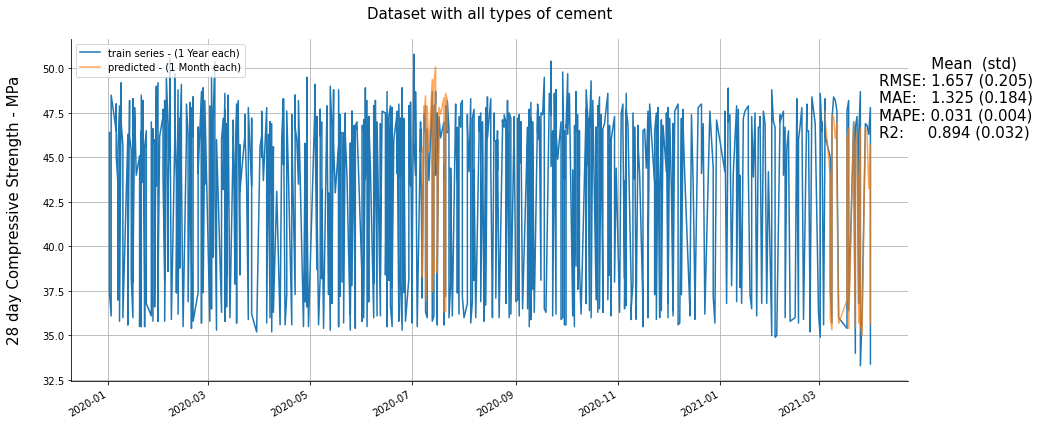

In [918]:
tmp = df[["Date", "28 day Compressive strength"]].dropna().copy()
tmp["Date"] = pd.to_datetime(tmp["Date"])
tmp = tmp.rename({"Production": "Date"}, axis=1)
tmp = tmp.set_index("Date")
tmp = tmp.iloc[: (start + step) * 2]

pred_series_0 = y_hat[0]
pred_series_0 = pd.DataFrame(
    {"ccs28-pred": pred_series_0}, index=pd.to_datetime(index[0])
)

pred_series_1 = y_hat[1]
pred_series_1 = pd.DataFrame(
    {"ccs28-pred": pred_series_1}, index=pd.to_datetime(index[1])
)


fig, ax = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(15, 7))

tmp.plot(ax=ax)
pred_series_0.plot(ax=ax, color="C1", alpha=0.7)
pred_series_1.plot(ax=ax, color="C1", alpha=0.7)

ax.grid(which="both")
ax.legend(["28 day compressive strength"], loc="upper left")

# ax.set_xlabel("Dates", labelpad=20, fontsize=15)
ax.set_xlabel("", labelpad=20, fontsize=15)
ax.set_ylabel("Compressive Strength - MPa", labelpad=20, fontsize=15)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# ax.axvline(pred_series_0.index[0], color="r")  # end of train dataset
# ax.axvline(pred_series_1.index[0], color="r")  # end of train dataset

ax.legend(["train series - (1 Year each)", "predicted - (1 Month each)"], loc="upper left")#loc="upper left")

#ax.set_xlabel("Trains a year and a month and predict a month for each year", labelpad=20, fontsize=15)
ax.set_ylabel("28 day Compressive Strength - MPa", labelpad=20, fontsize=15)

ax.text(
    pred_series_1.index[-1] + pd.DateOffset(5),
    45,
    results_str,
    fontsize=15,
    verticalalignment="bottom",
    horizontalalignment="left",
    #multialignment="center",
    #fontweight="ultrabold"
)

ax.set_title("Dataset with all types of cement", fontsize=15, pad=20)

plt.show()

# 3. LSTM

<h2>1. Dataset: df_no_cs</h2> <br>In this dataset the CS1, CS3  and CS7 variables are not considered.

In [942]:
df = pd.read_csv("../../../../../data/interim/partner_i-Oficial/cement-shipping.csv")

In [943]:
df = pd.get_dummies(data=df, columns=["Remarks"], drop_first=True)

<h2>Dataset: df_no_cs</h2> <br>In this dataset the CS1, CS3  and CS7 variables are not considered.

In [945]:
df_no_cs = df.drop(
    [
        "1 day Compressive strength",
        "3 day Compressive strength",
        "7 day Compressive strength",
    ],
    axis=1,
).copy()

y = df_no_cs.pop('28 day Compressive strength')
x = df_no_cs.drop(['Date'], axis=1)
df_copy = pd.concat([x, y], axis=1)

### 3.1 Train 1 year and predicts one month every year

In [951]:
start = time.time()
timesteps = 14
set_seeds()
x, y = split_sequences(df_copy.values, timesteps)
scores, y_results = repeated_blocking_time_series_nn(
    LSTM,
    StandardScaler3DShape,
    x,
    y,
    train_period=365,
    test_period=30,
    repeats=10,
)
print("TIMESTEPS: %d " % timesteps)
print_scores(scores[0], METRICS, METRICS_DICT)

end = time.time()
print("Minutes Elapsed: ", (end - start) / 60)

TIMESTEPS: 14 
******
[TRAIN]
******
RMSE: 1.410 (0.269)
MAE: 1.145 (0.264)
MAPE: 0.026 (0.006)
R2: 0.919 (0.034)


******
[TEST]
******
RMSE: 2.029 (0.657)
MAE: 1.635 (0.502)
MAPE: 0.039 (0.012)
R2: 0.821 (0.159)


Minutes Elapsed:  11.50834184885025


In [956]:
y_results_mean = np.mean(y_results, axis=0)
y_hat = y_results_mean.squeeze().squeeze().squeeze()

start = 365
step = 30
indices_start = [i for i in range(start, x.shape[0], start+step)]
indices_start
index = [df["Date"][start:start+step].values for start in indices_start]

results_str = """           Mean  (std)
RMSE: 2.029 (0.657)
MAE:   1.635 (0.502)
MAPE: 0.039 (0.012)
R2:     0.821 (0.159)
"""

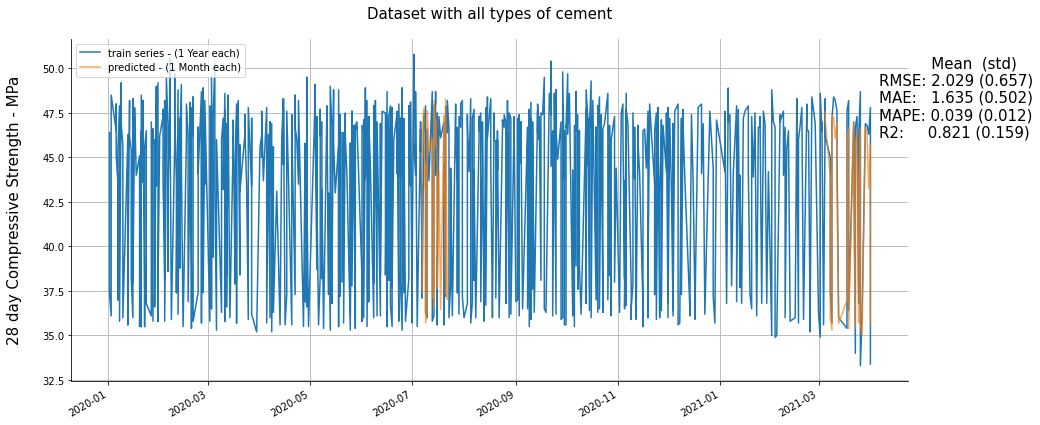

In [957]:
tmp = df[["Date", "28 day Compressive strength"]].dropna().copy()
tmp["Date"] = pd.to_datetime(tmp["Date"])
tmp = tmp.rename({"Production": "Date"}, axis=1)
tmp = tmp.set_index("Date")
tmp = tmp.iloc[: (start + step) * 2]

pred_series_0 = y_hat[0]
pred_series_0 = pd.DataFrame(
    {"ccs28-pred": pred_series_0}, index=pd.to_datetime(index[0])
)

# pred_series_1 = y_hat[1]
# pred_series_1 = pd.DataFrame(
#     {"ccs28-pred": pred_series_1}, index=pd.to_datetime(index[1])
# )


fig, ax = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(15, 7))

tmp.plot(ax=ax)
pred_series_0.plot(ax=ax, color="C1", alpha=0.7)
pred_series_1.plot(ax=ax, color="C1", alpha=0.7)

ax.grid(which="both")
ax.legend(["28 day compressive strength"], loc="upper left")

# ax.set_xlabel("Dates", labelpad=20, fontsize=15)
ax.set_xlabel("", labelpad=20, fontsize=15)
ax.set_ylabel("Compressive Strength - MPa", labelpad=20, fontsize=15)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# ax.axvline(pred_series_0.index[0], color="r")  # end of train dataset
# ax.axvline(pred_series_1.index[0], color="r")  # end of train dataset

ax.legend(["train series - (1 Year each)", "predicted - (1 Month each)"], loc="upper left")#loc="upper left")

#ax.set_xlabel("Trains a year and a month and predict a month for each year", labelpad=20, fontsize=15)
ax.set_ylabel("28 day Compressive Strength - MPa", labelpad=20, fontsize=15)

ax.text(
    pred_series_1.index[-1] + pd.DateOffset(5),
    45,
    results_str,
    fontsize=15,
    verticalalignment="bottom",
    horizontalalignment="left",
    #multialignment="center",
    #fontweight="ultrabold"
)

ax.set_title("Dataset with all types of cement", fontsize=15, pad=20)

plt.show()

# CPIIF40 - Dataset

In [980]:
## Reading the dataset

df = pd.read_csv("../../../../../data/interim/partner_i-Oficial/cpiif40.csv")

In [981]:
df_no_cs = df.drop(
    [
        "1 day Compressive strength",
        "3 day Compressive strength",
        "7 day Compressive strength",
    ],
    axis=1,
).copy()

y = df_no_cs.pop('28 day Compressive strength').values
x = df_no_cs.drop(['Date'], axis=1).values

# 4. Linear Regression

<h2>Dataset: df_no_cs</h2> <br>In this dataset the CS1, CS3  and CS7 variables are not considered.

### 4.1 Train 6 months and predicts one month every year

In [994]:
scores, y_results = repeated_blocking_time_series(
    LinearRegression,
    StandardScaler,
    x,
    y,
    train_period=180,
    test_period=30,
    repeats=1,
)
print_scores(scores[0], METRICS, METRICS_DICT)


******
[TRAIN]
******
RMSE: 0.739 (0.062)
MAE: 0.578 (0.046)
MAPE: 0.012 (0.001)
R2: 0.403 (0.073)


******
[TEST]
******
RMSE: 0.763 (0.094)
MAE: 0.619 (0.050)
MAPE: 0.013 (0.001)
R2: 0.245 (0.091)




In [998]:
y_results_mean = np.mean(y_results, axis=0)
y_hat = y_results_mean

start = 180
step = 30
indices_start = [i for i in range(start, x.shape[0], start+step)]
indices_start
index = [df_no_cs["Date"][start:start+step].values for start in indices_start]

results_str = """           Mean  (std)
RMSE: 0.763 (0.094)
MAE:   0.619 (0.050)
MAPE: 0.013 (0.001)
R2:     0.245 (0.091)
"""

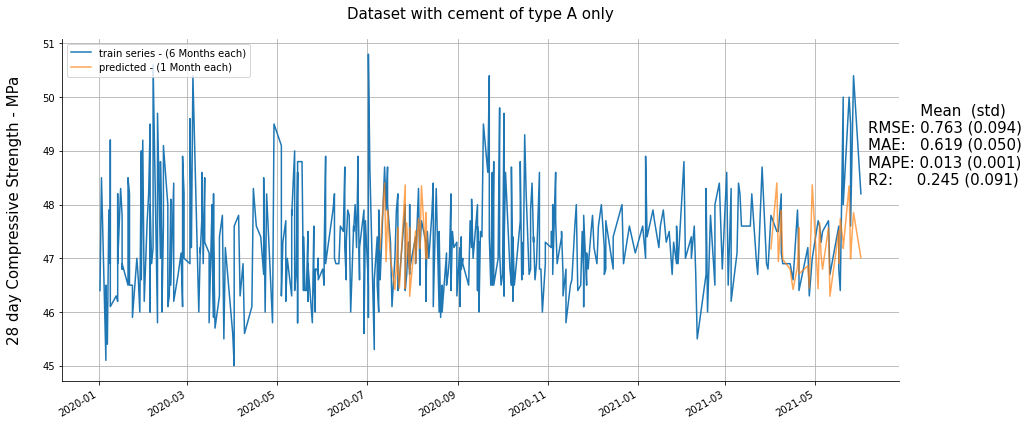

In [1021]:
tmp = df[["Date", "28 day Compressive strength"]].dropna().copy()
tmp["Date"] = pd.to_datetime(tmp["Date"])
tmp = tmp.rename({"Production": "Date"}, axis=1)
tmp = tmp.set_index("Date")
tmp = tmp.iloc[: (start + step) * 2]

pred_series_0 = y_hat
pred_series_0 = pd.DataFrame(
    {"ccs28-pred": pred_series_0}, index=pd.to_datetime(index[0])
)

pred_series_1 = y_hat
pred_series_1 = pd.DataFrame(
    {"ccs28-pred": pred_series_1}, index=pd.to_datetime(index[1])
)


fig, ax = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(15, 7))

tmp.plot(ax=ax)
pred_series_0.plot(ax=ax, color="C1", alpha=0.7)
pred_series_1.plot(ax=ax, color="C1", alpha=0.7)

ax.grid(which="both")
ax.legend(["28 day compressive strength"], loc="upper left")

# ax.set_xlabel("Dates", labelpad=20, fontsize=15)
ax.set_xlabel("", labelpad=20, fontsize=15)
ax.set_ylabel("Compressive Strength - MPa", labelpad=20, fontsize=15)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# ax.axvline(pred_series_0.index[0], color="r")  # end of train dataset
# ax.axvline(pred_series_1.index[0], color="r")  # end of train dataset

ax.legend(["train series - (6 Months each)", "predicted - (1 Month each)"], loc="upper left")#loc="upper left")

#ax.set_xlabel("Trains a year and a month and predict a month for each year", labelpad=20, fontsize=15)
ax.set_ylabel("28 day Compressive Strength - MPa", labelpad=20, fontsize=15)

ax.text(
    pred_series_1.index[-1] + pd.DateOffset(5),
    48,
    results_str,
    fontsize=15,
    verticalalignment="bottom",
    horizontalalignment="left",
    #multialignment="center",
    #fontweight="bold"
)

ax.set_title("Dataset with cement of type A only", fontsize=15, pad=20)

plt.show()

# CPIIF32 - Dataset

## Reading the dataset

In [1053]:
df = pd.read_csv("../../../../../data/interim/partner_i-Oficial/cpiif32.csv")

In [1054]:
df_no_cs = df.drop(
    [
        "1 day Compressive strength",
        "3 day Compressive strength",
        "7 day Compressive strength",
    ],
    axis=1,
).copy()

y = df_no_cs.pop('28 day Compressive strength').values
x = df_no_cs.drop(['Date'], axis=1).values

# 5. MLP

<h2>1. Dataset: df_no_cs</h2> <br>In this dataset the CS1, CS3  and CS7 variables are not considered.

### 5.1 Train 1 years and predicts one month

In [1055]:
set_seeds()
start = time.time()

scores, y_results = repeated_blocking_time_series_nn(
    MLP,
    StandardScaler,
    x,
    y,
    train_period=365,
    test_period=30,
    repeats=10,
)
print_scores(scores[0], METRICS, METRICS_DICT)

end = time.time()
print("Minutes Elapsed: ", (end - start) / 60)

******
[TRAIN]
******
RMSE: 1.101 (0.096)
MAE: 0.854 (0.068)
MAPE: 0.023 (0.002)
R2: 0.003 (0.185)


******
[TEST]
******
RMSE: 1.500 (0.203)
MAE: 1.228 (0.184)
MAPE: 0.033 (0.005)
R2: 1.162 (0.598)


Minutes Elapsed:  1.7030631621678671


In [1056]:
y_results_mean = np.mean(y_results, axis=0)
y_hat = y_results_mean.squeeze().squeeze().squeeze()

start = 365
step = 30
indices_start = [i for i in range(start, x.shape[0], start+step)]
indices_start
index = [df["Date"][start:start+step].values for start in indices_start]

results_str = """           Mean  (std)
RMSE: 1.500 (0.203)
MAE:   1.228 (0.184)
MAPE: 0.033 (0.005)
R2:     1.162 (0.598)
"""

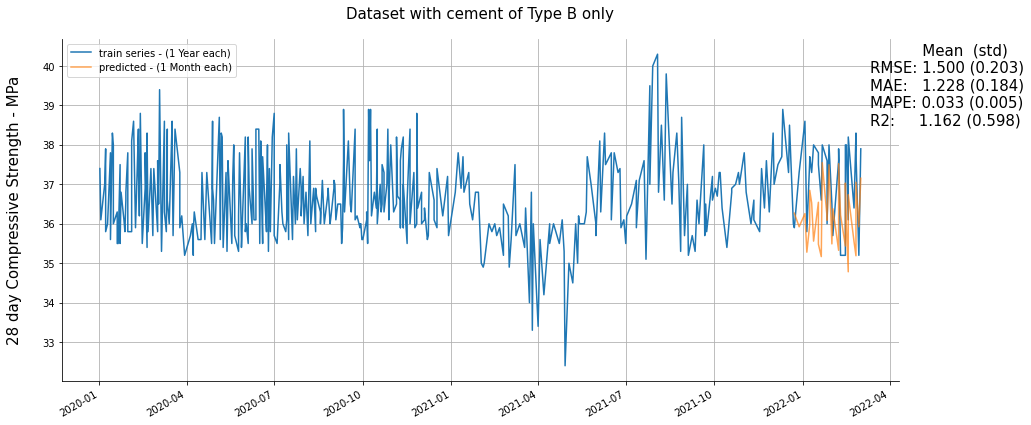

In [1057]:
tmp = df[["Date", "28 day Compressive strength"]].dropna().copy()
tmp["Date"] = pd.to_datetime(tmp["Date"])
tmp = tmp.rename({"Production": "Date"}, axis=1)
tmp = tmp.set_index("Date")
tmp = tmp.iloc[: (start + step) * 1]

pred_series_0 = y_hat
pred_series_0 = pd.DataFrame(
    {"ccs28-pred": pred_series_0}, index=pd.to_datetime(index[0])
)

# pred_series_1 = y_hat
# pred_series_1 = pd.DataFrame(
#     {"ccs28-pred": pred_series_1}, index=pd.to_datetime(index[1])
# )


fig, ax = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(15, 7))

tmp.plot(ax=ax)
pred_series_0.plot(ax=ax, color="C1", alpha=0.7)
#pred_series_1.plot(ax=ax, color="C1", alpha=0.7)

ax.grid(which="both")
ax.legend(["28 day compressive strength"], loc="upper left")

# ax.set_xlabel("Dates", labelpad=20, fontsize=15)
ax.set_xlabel("", labelpad=20, fontsize=15)
ax.set_ylabel("Compressive Strength - MPa", labelpad=20, fontsize=15)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# ax.axvline(pred_series_0.index[0], color="r")  # end of train dataset
# ax.axvline(pred_series_1.index[0], color="r")  # end of train dataset

ax.legend(["train series - (1 Year each)", "predicted - (1 Month each)"], loc="upper left")#loc="upper left")

#ax.set_xlabel("Trains a year and a month and predict a month for each year", labelpad=20, fontsize=15)
ax.set_ylabel("28 day Compressive Strength - MPa", labelpad=20, fontsize=15)

ax.text(
    pred_series_0.index[-1] + pd.DateOffset(10),
    38,
    results_str,
    fontsize=15,
    verticalalignment="bottom",
    horizontalalignment="left",
    #multialignment="center",
    #fontweight="ultrabold"
)

ax.set_title("Dataset with cement of Type B only", fontsize=15, pad=20)

plt.show()

# CPVARI - Dataset

## Reading the dataset

In [1058]:
df = pd.read_csv("../../../../../data/interim/partner_i-Oficial/cpvari.csv")

In [1059]:
df_no_cs = df.drop(
    [
        "1 day Compressive strength",
        "3 day Compressive strength",
        "7 day Compressive strength",
    ],
    axis=1,
).copy()

y = df_no_cs.pop('28 day Compressive strength')
x = df_no_cs.drop(['Date'], axis=1)
df_copy = pd.concat([x, y], axis=1)

# 6. LSTM

<h2>1. Dataset: df_no_cs</h2> <br>In this dataset the CS1, CS3  and CS7 variables are not considered.

### 6.1 Train 6 months and predicts one month every year

In [1060]:
start = time.time()
timesteps = 7
set_seeds()
x, y = split_sequences(df_copy.values, timesteps)
scores, y_results = repeated_blocking_time_series_nn(
    LSTM,
    StandardScaler3DShape,
    x,
    y,
    train_period=180,
    test_period=30,
    repeats=10,
)
print("TIMESTEPS: %d " % timesteps)
print_scores(scores[0], METRICS, METRICS_DICT)

end = time.time()
print("Minutes Elapsed: ", (end - start) / 60)

TIMESTEPS: 7 
******
[TRAIN]
******
RMSE: 1.412 (0.112)
MAE: 1.124 (0.089)
MAPE: 0.025 (0.002)
R2: 0.126 (0.134)


******
[TEST]
******
RMSE: 2.637 (0.486)
MAE: 2.322 (0.475)
MAPE: 0.049 (0.010)
R2: 4.806 (2.236)


Minutes Elapsed:  1.411133623123169


In [1064]:
y_results_mean = np.mean(y_results, axis=0)
y_hat = y_results_mean.squeeze().squeeze().squeeze()

start = 180
step = 30
indices_start = [i for i in range(start, x.shape[0], start+step)]
indices_start
index = [df["Date"][start:start+step].values for start in indices_start]

results_str = """           Mean  (std)
RMSE: 2.637 (0.486)
MAE:   2.322 (0.475)
MAPE: 0.049 (0.010)
R2:     4.806 (2.236)
"""

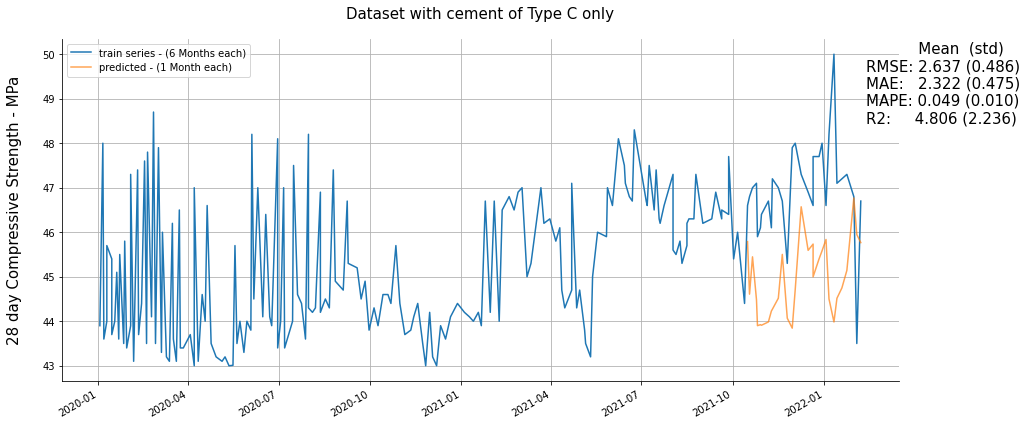

In [1067]:
tmp = df[["Date", "28 day Compressive strength"]].dropna().copy()
tmp["Date"] = pd.to_datetime(tmp["Date"])
tmp = tmp.rename({"Production": "Date"}, axis=1)
tmp = tmp.set_index("Date")
tmp = tmp.iloc[: (start + step) * 1]

pred_series_0 = y_hat
pred_series_0 = pd.DataFrame(
    {"ccs28-pred": pred_series_0}, index=pd.to_datetime(index[0])
)

# pred_series_1 = y_hat[1]
# pred_series_1 = pd.DataFrame(
#     {"ccs28-pred": pred_series_1}, index=pd.to_datetime(index[1])
# )


fig, ax = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(15, 7))

tmp.plot(ax=ax)
pred_series_0.plot(ax=ax, color="C1", alpha=0.7)
#pred_series_1.plot(ax=ax, color="C1", alpha=0.7)

ax.grid(which="both")
ax.legend(["28 day compressive strength"], loc="upper left")

# ax.set_xlabel("Dates", labelpad=20, fontsize=15)
ax.set_xlabel("", labelpad=20, fontsize=15)
ax.set_ylabel("Compressive Strength - MPa", labelpad=20, fontsize=15)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# ax.axvline(pred_series_0.index[0], color="r")  # end of train dataset
# ax.axvline(pred_series_1.index[0], color="r")  # end of train dataset

ax.legend(["train series - (6 Months each)", "predicted - (1 Month each)"], loc="upper left")#loc="upper left")

#ax.set_xlabel("Trains a year and a month and predict a month for each year", labelpad=20, fontsize=15)
ax.set_ylabel("28 day Compressive Strength - MPa", labelpad=20, fontsize=15)

ax.text(
    pred_series_0.index[-1] + pd.DateOffset(5),
    48,
    results_str,
    fontsize=15,
    verticalalignment="bottom",
    horizontalalignment="left",
    #multialignment="center",
    #fontweight="ultrabold"
)

ax.set_title("Dataset with cement of Type C only", fontsize=15, pad=20)

plt.show()